In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
import matplotlib as plt
from itertools import chain
import ast

In [10]:
df = pd.read_csv("../data/full_set.csv")
df.shape

(588793, 31)

In [11]:
TARGET_CLASS = "CHM2210"

# converts strings to arrays
df['Classes'] = df['Classes'].apply(ast.literal_eval)
df['Semester Grades'] = df['Semester Grades'].apply(ast.literal_eval)
df['Semester Points'] = df['Semester Points'].apply(ast.literal_eval)
df['CRN'] = df['CRN'].apply(ast.literal_eval)

# find all people who took class
Pidms_with_TARGET_CLASS = df[df['Classes'].apply(lambda x: TARGET_CLASS in x)]['Pidm'].unique()
df = df[df['Pidm'].isin(Pidms_with_TARGET_CLASS)]
df = df[['Pidm', 'Semester', 'HS GPA', 'Converted_SAT', 'Semester Points', 'Semester Grades', 'CRN', 'Classes']]
df.head(4)

# Find the first semester with TARGET_CLASS for each student
def find_first_semester(student_df):
    chm2210_row = student_df[student_df['Classes'].apply(lambda x: TARGET_CLASS in x)]
    if not chm2210_row.empty:
        return chm2210_row['Semester'].min()
    return None

first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
df = df.merge(first_semester, on='Pidm')

# filter all semesters after student took TARGET_CLASS
filtered_df = df[df['Semester'] <= df['Target_Semester']]

# find grades/points for TARGET_CLASS and output it to a new column
def find_class_grades(student_df):
    for _, row in student_df.iterrows():
        if TARGET_CLASS in row['Classes']:
            index = row['Classes'].index(TARGET_CLASS)
            return row['Semester Points'][index], row['Semester Grades'][index]
    return None, None

class_grades = filtered_df.groupby('Pidm').apply(lambda x: find_class_grades(x)).apply(pd.Series)
class_grades.columns = ['Target_Points', 'Target_Grade']

final_df = filtered_df.merge(class_grades, on='Pidm')

# filter out these grades
final_df = final_df[~final_df['Target_Grade'].isin(['WE', 'IF', 'W', 'WC'])]

display(df[df['Pidm'] ==  134328])
final_df = final_df[final_df['Semester'] < final_df['Target_Semester']]
display(final_df[final_df['Pidm'] ==  134328])
groupped_df = final_df.groupby('Pidm').agg({
    "HS GPA": 'first',
    'Converted_SAT': 'first',
    'Semester Grades': lambda x: sum(x, []),
    'Semester Points': lambda x: sum(x, []),
    'Classes': lambda x: sum(x, []),
    'CRN': lambda x: sum(x, []),
    'Target_Grade': 'first',
    'Target_Points': 'first',
}).reset_index()

all_classes = sorted(set(chain.from_iterable(groupped_df['Classes'])))

def create_one_hot(classes, points, all_classes):
    one_hot_vector = [-1] * len(all_classes)
    for class_name, point in zip(classes, points):
        if class_name in all_classes:
            one_hot_vector[all_classes.index(class_name)] = point
    return one_hot_vector

groupped_df['One_Hot_Classes'] = groupped_df.apply(
    lambda row: create_one_hot(row['Classes'], row['Semester Points'], all_classes), axis=1
)

one_hot_df = pd.DataFrame(groupped_df['One_Hot_Classes'].tolist(), columns=all_classes, index=groupped_df['Pidm'])

from sklearn.model_selection import train_test_split

train, testing_data = train_test_split(one_hot_df, test_size=0.2, random_state=50)
dev, test = train_test_split(testing_data, test_size=0.5, random_state=50)

train_set = one_hot_df[one_hot_df.index.isin(train.index)]
dev_set = one_hot_df[one_hot_df.index.isin(dev.index)]
test_set = one_hot_df[one_hot_df.index.isin(test.index)]
columns_to_remove = []
for column in train_set.columns:
    value_counts = train_set[column].value_counts()
    max_count = value_counts.max()
    non_max_count = value_counts.sum() - max_count
    
    if non_max_count <= 20:
        columns_to_remove.append(column)
        
train_set = train_set.drop(columns=columns_to_remove)
dev_set = dev_set.drop(columns=columns_to_remove)
test_set = test_set.drop(columns=columns_to_remove)

print(train_set.shape, dev_set.shape, test_set.shape)

/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_19190/1276092254.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  first_semester = df.groupby('Pidm').apply(lambda x: find_first_semester(x)).rename('Target_Semester')
/var/folders/_5/9jdkhcr55fs4c8fnv6cxprt40000gn/T/ipykernel_19190/1276092254.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_grades = filtered_df.groupby('Pidm').apply(l

,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708
3,134328,201708,3.0,1370.0,"[1.0, 1.33, 0.0, 2.33]","[D, D+, F, C+]","[86672.0, 87939.0, 88312.0, 91803.0]","[CHM2210, PCB3063, CHM2210L, EGS3720]",201708
4,134328,201808,3.0,1370.0,"[4.0, 0.0]","[A, S]","[80885.0, 89183.0]","[COP2510, EGN3000]",201708
5,134328,201901,3.0,1370.0,"[1.0, 0.0, 0.0]","[D, F, F]","[17655.0, 18741.0, 19361.0]","[COP3514, COT3100, CDA3103]",201708


,Pidm,Semester,HS GPA,Converted_SAT,Semester Points,Semester Grades,CRN,Classes,Target_Semester,Target_Points,Target_Grade
0,134328,201601,3.0,1370.0,"[2.0, 3.0]","[C, B]","[11143.0, 23005.0]","[BSC2010L, BSC2010]",201708,1.0,D
1,134328,201701,3.0,1370.0,[4.0],[A],[11691.0],[ENC1101],201708,1.0,D
2,134328,201705,3.0,1370.0,"[3.0, 3.67]","[B, A-]","[52696.0, 52892.0]","[PSY2012, ARC2211]",201708,1.0,D


(9424, 355) (1178, 355) (1179, 355)


In [12]:
train_set

,ACG2021,ACG2071,AFA2000,AFA4335,AFR1101,AFR2001,AMH2010,AMH2020,AMS2270,AMS3700,ANT2000,ANT2410,ANT2511,ANT2511L,ANT3101,ANT3610,ANT4401,ANT4930,APK3120,ARC2211,ARH2000,ARH2050,ARH2051,ARH3001,ART2201C,ART2301C,ASL2140C,ASL2150C,ASL3514,AST2002,AST2004,BME3053,BME4100,BSC1005,BSC1020,BSC2010,BSC2010L,BSC2011,BSC2011L,BSC2085,BSC2085L,BSC2086,BSC2086L,BSC2093C,BSC2094C,BSC2932,BSC3312,BSC3402L,BSC3453,BSC4057,BSC4910,BSC4933,BUL3320,CCJ3014,CCJ3024,CCJ3117,CCJ3621,CCJ4613,CCJ4651,CCJ4933,CGS2060,CGS2100,CHM2023,CHM2045,CHM2045L,CHM2046,CHM2046L,CHM3120C,CHS2440,CHS2440L,CJE3650,CLA3103,CLA3124,CLP4143,CLP4314,CLP4433,CLT3040,CLT3370,COM2000,COP2510,CPO2002,CRW2100,CRW3111,DAN2100,DEP2004,DEP4053,ECH3002,ECH3023,ECH3266,ECH3854,ECH4846,ECH4931,ECO1000,ECO2013,ECO2023,EDF2085,EDF3604,EDG2930,EGN1113,EGN3000,EGN3000L,EGN3311,EGN3343,EGN3433,EGN3443,EGN3615,EGN4905,EGN4930,EGS3011,EGS3720,EMA4003,EME4390,ENC1101,ENC1102,ENC2210,ENC3241,ENC3246,ENC3250,ENC3310,ENG3674,ENG4674,ENT3003,ESC2000,EUH2011,EVR2001,EVR2001L,EVR2861,EVR3218,EVR4027,EVR4114,EVR4930,EXP4304,EXP4680C,FIL1002,FIL3854,FIN2100,FRE1120,FRE1121,GEA2000,GEO2200,GEO2400,GEO4372,GER1120,GEY2000,GEY3601,GEY3625,GEY4102,GEY4612,GEY4641,GEY4647,GIS3006,GLY2000L,GLY2010,GLY2100,GLY4734,HFT3894,HFT4930,HIS3308,HIS3938,HSC2000,HSC2100,HSC2130,HSC2400,HSC3002,HSC3503,HSC4172,HSC4211,HSC4430,HSC4504,HSC4537,HSC4551,HSC4573,HSC4579,HSC4624,HSC4630,HSC4631,HUM1020,HUM2230,HUM2250,HUM2593,HUM4938,HUN2201,HUN3126,HUN3272,HUN3296,IDH2010,IDH2930,IDH3100,IDH3350,IDH3400,IDH3600,IDH4200,IDH4930,IDH4950,IDS2378,IDS2912,IDS3947,IDS4914,INR3011,ISM3011,ISS3420,JPN1120,LAE4414,LAH2020,LDR2010,LDR3301,LDR4204,LIN2002,LIN3003,LIS2005,LIS4785,LIS4930,LIT2000,LIT3103,LIT3301,LIT3353,LIT3374,LIT3410,MAC1105,MAC1147,MAC2233,MAC2241,MAC2242,MAC2281,MAC2282,MAC2283,MAC2311,MAC2312,MAC2313,MAN3025,MAP2302,MAR3023,MAT1033,MCB2000,MCB2000L,MCB3020,MCB3020L,MCB3410,MCB4905,MGF1106,MHS2031,MHS3063,MHS3411,MHS4452,MHS4703,MMC2110,MMC3602,MSL1001C,MSL1002C,MUC2301,MUH2020,MUH3016,MUL2010,MUL3001,MUL3011,MUN1100,MUN1110,MUN3143,MUS4930,OCE2001,OCE4930,PAD3003,PAD4930,PCB3023,PCB3023L,PCB3043,PCB3043L,PCB3063,PCB3063L,PCB3712,PCB3713L,PCB4674,PEM2131,PEM2930,PHC2100,PHC3302,PHC3320,PHC4030,PHC4031,PHC4032,PHC4069,PHC4101,PHC4464,PHC4720,PHH2000,PHI1103,PHI1401,PHI1600,PHI2010,PHI2630,PHI3633,PHI3636,PHI3640,PHI4320,PHY2020,PHY2048,PHY2048L,PHY2049,PHY2049L,PHY2053,PHY2053L,PHY2054,PHY2054L,PHY2060,PHZ2102,PHZ2103,POS2041,PPE4003,PSB3444,PSB4004C,PSC2515,PSY2012,PSY3204,PSY3213,RCS4452,REL2166,REL2300,REL3167,REL3191,REL3375,REL3850,REL3936,SLS1101,SLS1107,SLS2122,SLS2901,SLS3275,SLS3717,SOP4004,SOW3802,SPA3002,SPA3470,SPC2608,SPC3710,SPM3012,SPN1120,SPN1121,SPN2200,SPN2201,SPN3300,STA2023,STA2122,SYD3700,SYG2000,SYG2010,SYO4400,SYP3000,THE2000,THE2252,THE4574,WOH2030,WST2250,WST2600,WST3015,WST3324
Pidm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
706382,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,4.00,4.0,4.00,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-

In [13]:
# Integrate the main groupped_df data with train, dev, test sets using the 'Pidm' index for additional features
train_set = train_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
dev_set = dev_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])
test_set = test_set.join(groupped_df.set_index('Pidm')[['HS GPA', 'Converted_SAT', 'Target_Grade']])

# Define a mapping for each letter grade to a unique class label
grade_mapping = {
    'A+': 0, 'A': 0, 'A-': 0,  # Class 0: A
    'B+': 1, 'B': 1, 'B-': 1,  # Class 1: B
    'C+': 2, 'C': 2, 'C-': 2,  # Class 2: C
    'D+': 3, 'D': 3, 'D-': 3, 'F': 3  # Class 3: Fail
}

train_set['Target_Class'] = train_set['Target_Grade'].map(grade_mapping)
dev_set['Target_Class'] = dev_set['Target_Grade'].map(grade_mapping)
test_set['Target_Class'] = test_set['Target_Grade'].map(grade_mapping)

train_set.dropna(subset=['Target_Class'], inplace=True)
dev_set.dropna(subset=['Target_Class'], inplace=True)
test_set.dropna(subset=['Target_Class'], inplace=True)

In [14]:
# Define features (X) and targets (y)
X_train = train_set.drop(columns=['Target_Grade', 'Target_Class'])
X_dev = dev_set.drop(columns=['Target_Grade', 'Target_Class'])
X_test = test_set.drop(columns=['Target_Grade', 'Target_Class'])
y_train = train_set['Target_Class'].astype(int)
y_dev = dev_set['Target_Class'].astype(int)
y_test = test_set['Target_Class'].astype(int)

# Final verification
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_dev shape:", X_dev.shape)
print("y_dev shape:", y_dev.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9374, 357)
y_train shape: (9374,)
X_dev shape: (1172, 357)
y_dev shape: (1172,)
X_test shape: (1173, 357)
y_test shape: (1173,)


Accuracy: 0.52
Confusion Matrix:
 [[269  84  16   2]
 [113 191  91  14]
 [ 19  95 117  27]
 [  8  34  64  29]]
Classification Report:
               precision    recall  f1-score   support

     A class       0.66      0.73      0.69       371
     B class       0.47      0.47      0.47       409
     C class       0.41      0.45      0.43       258
        Fail       0.40      0.21      0.28       135

    accuracy                           0.52      1173
   macro avg       0.48      0.47      0.47      1173
weighted avg       0.51      0.52      0.51      1173



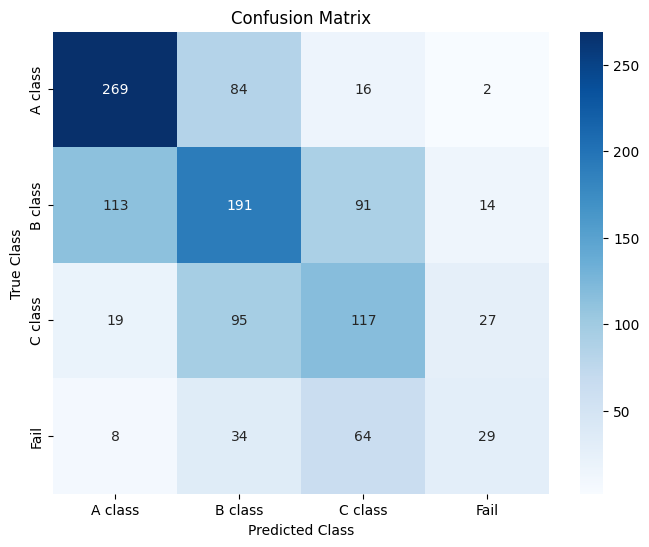

In [26]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': 4,               # Number of classes
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500,
    'subsample': 0.8,
    'seed': 42
}

# Initialize the XGBoost classifier with your parameters
xgb_classifier = xgb.XGBClassifier(**params)

# Fit the model to the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = xgb_classifier.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Define class names for better readability
class_names = ['A class', 'B class', 'C class', 'Fail']

# Modify classification report with class names
class_report = classification_report(y_test, y_test_pred, target_names=class_names)

# Print evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight='balanced',
    min_samples_split=5
)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
class_names = ["A", "B", "C", "Fail"]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.51
              precision    recall  f1-score   support

           A       0.66      0.75      0.70       371
           B       0.47      0.41      0.44       409
           C       0.40      0.51      0.45       258
        Fail       0.32      0.17      0.22       135

    accuracy                           0.51      1173
   macro avg       0.46      0.46      0.45      1173
weighted avg       0.50      0.51      0.50      1173

Confusion Matrix:
 [[278  74  16   3]
 [124 166 106  13]
 [ 16  77 131  34]
 [  6  34  72  23]]


In [68]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(multi_class='multinomial', max_iter=700, solver='lbfgs')
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
class_names = ["A", "B", "C", "Fail"]

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=class_names))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.42625745950554134
              precision    recall  f1-score   support

           A       0.50      0.61      0.55       371
           B       0.40      0.40      0.40       409
           C       0.37      0.38      0.37       258
        Fail       0.26      0.09      0.13       135

    accuracy                           0.43      1173
   macro avg       0.38      0.37      0.36      1173
weighted avg       0.41      0.43      0.41      1173

Confusion Matrix:
 [[227 106  34   4]
 [147 163  82  17]
 [ 50  96  98  14]
 [ 26  44  53  12]]


/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=700)
knn_model.fit(X_train, y_train)
y_pred = knn_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.41261722080136404
              precision    recall  f1-score   support

           0       0.46      0.64      0.54       371
           1       0.38      0.45      0.41       409
           2       0.37      0.24      0.29       258
           3       0.00      0.00      0.00       135

    accuracy                           0.41      1173
   macro avg       0.30      0.33      0.31      1173
weighted avg       0.36      0.41      0.38      1173



/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

Top 20 Features by Importance:
     Feature  Importance
65   CHM2046    0.030836
63   CHM2045    0.006577
5    AFR2001    0.004559
136  FRE1120    0.004370
210  LIS4785    0.004300
244  MHS4703    0.004171
15   ANT3610    0.004061
333  SPC3710    0.004046
215  LIT3353    0.003912
203  LAH2020    0.003843
254  MUL3011    0.003799
120  ENG4674    0.003731
213  LIT3103    0.003729
101  EGN3311    0.003711
240  MHS2031    0.003656
22   ARH2051    0.003650
1    ACG2071    0.003649
306  POS2041    0.003648
315  REL2166    0.003603
3    AFA4335    0.003601


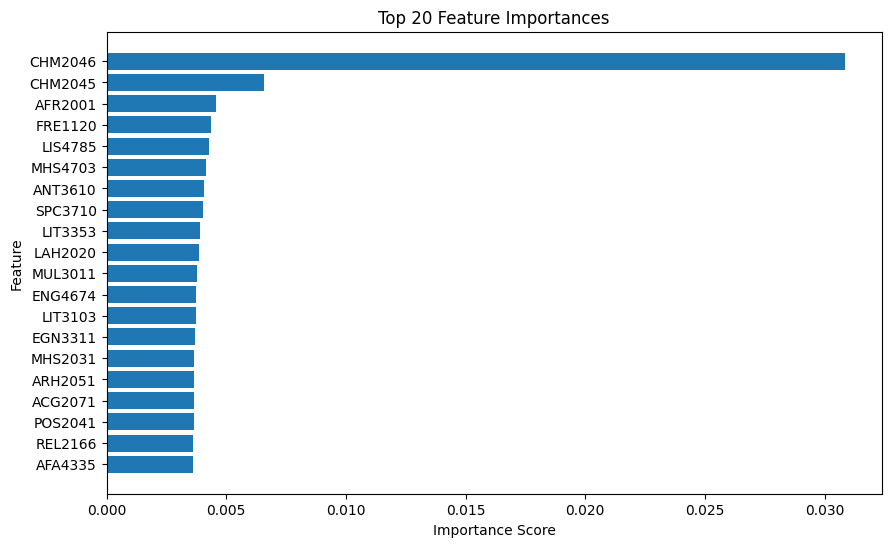

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importance = xgb_classifier.feature_importances_

# Match the feature importances with their respective column names
feature_names = X_train.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Print the top 10 features for analysis
print("Top 20 Features by Importance:")
print(importance_df.head(20))

# Visualize the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Feature Importances")
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define your custom parameters
params = {
    'objective': 'multi:softmax',  # Multi-class classification
    'num_class': len(grade_mapping),  # Number of classes
    'colsample_bytree': 0.8,
    'learning_rate': 0.01,
    'max_depth': 10,
    'n_estimators': 500,
    'subsample': 0.8,
    'seed': 42  # For reproducibility
}

# Initialize the XGBoost classifier with your parameters
xgb_classifier = xgb.XGBClassifier(**params)

# Fit the model to the training data
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_test_pred = xgb_classifier.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_test_pred)
conf_matrix = confusion_matrix(y_test, y_test_pred)
class_report = classification_report(y_test, y_test_pred)

# Print evaluation results
print(f"Accuracy: {accuracy:.2f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)


Accuracy: 0.30
Confusion Matrix:
 [[214   9  15  12   0   3   4   0   0   1   1]
 [ 68   3  10  14   3   4   8   0   0   2   0]
 [ 60   5  11  20   2   8  16   0   0   2   1]
 [ 59   6  20  26   6  20  30   0   0   8   1]
 [ 17   4  11  22  10  17  18   0   0   9   0]
 [ 12   2   6  19   5  24  31   0   0  14   5]
 [ 10   2   6  17   6  15  38   0   0  16   5]
 [  1   0   5   1   0   4  11   0   0   3   0]
 [  0   0   0   1   0   0   1   0   0   1   0]
 [  5   1   3   6   6  10  35   0   0  15   7]
 [  5   1   2   4   3   4  12   0   0   6   7]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.83      0.60       259
           1       0.09      0.03      0.04       112
           2       0.12      0.09      0.10       125
           3       0.18      0.15      0.16       176
           4       0.24      0.09      0.13       108
           5       0.22      0.20      0.21       118
           6       0.19      0.33      0.24  

/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/nurmashtashenov/Desktop/ML Research Fall24/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th